# Bynary Classification With Pytorch

Machine Learning Model to predict if a patient has cancer or not.

Dataset https://www.kaggle.com/datasets/erdemtaha/cancer-data

## Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
import numpy as np

## Loading Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("erdemtaha/cancer-data")
print("Path to dataset files:", path)

/home/edubraz/anaconda3/envs/video-inference-analysis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /home/edubraz/.cache/kagglehub/datasets/erdemtaha/cancer-data/versions/1


In [4]:
df = pd.read_csv('data/Cancer_Data.csv')
print(df.info())
print("="*20)
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Exploring Dataset


In [5]:
diagnosis_counts = df['diagnosis'].value_counts()
diagnosis_counts_percentage = df['diagnosis'].value_counts(normalize=True)
print(diagnosis_counts)
print("="*20)
print(diagnosis_counts_percentage)


diagnosis
B    357
M    212
Name: count, dtype: int64
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64


## Data Preprocessing

In [6]:
# Drop unnecessary columns
df = df.drop(columns=['id', 'Unnamed: 32'])

# Convert diagnosis to binary: Malignant (M) = 1, Benign (B) = 0
df['diagnosis'] = df['diagnosis'].map({'M': 1.0, 'B': 0.0})

# Split features and target
X = df.drop(columns=['diagnosis'])
y = df['diagnosis'].astype(float)

In [7]:
# Normalize the features
scaler = StandardScaler()

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Pytorch Implementation

In [8]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create Datasets and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

## Define the Model

In [9]:
# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(30,60) # 30 input features
        self.fc2 = nn.Linear(60, 80)
        self.fc3 = nn.Linear(80, 100)
        self.fc4 = nn.Linear(100, 140)
        self.fc5 = nn.Linear(140, 180)
        self.fc6 = nn.Linear(180, 150)
        self.fc7 = nn.Linear(150, 100)
        self.fc8 = nn.Linear(100, 50)
        self.fc9 = nn.Linear(50, 25)
        self.fc10 = nn.Linear(25, 1)

        self.dropout = nn.Dropout(0.3) # 30% dropout
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout(x)
        x = torch.relu(self.fc5(x))
        x = self.dropout(x)
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = self.dropout(x)
        x = torch.relu(self.fc8(x))
        x = torch.relu(self.fc9(x))
        x = self.sigmoid(self.fc10(x))
        return x
    

model = SimpleNN()

criterion = nn.BCELoss() # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training the Model

In [10]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            labels = labels.unsqueeze(1) # Add a dimension to the targets tensor
            optimizer.zero_grad() # zero the gradients

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

train_model(model, train_loader, criterion, optimizer, num_epochs=40)


Epoch 1/40, Loss: 0.6929300824801127
Epoch 2/40, Loss: 0.5259195625782013
Epoch 3/40, Loss: 0.3971848517656326
Epoch 4/40, Loss: 0.3207229644060135
Epoch 5/40, Loss: 0.22968218773603438
Epoch 6/40, Loss: 0.07459146886443098
Epoch 7/40, Loss: 0.0645980402516822
Epoch 8/40, Loss: 0.04850556214805692
Epoch 9/40, Loss: 0.04827269930392504
Epoch 10/40, Loss: 0.030980885106449325
Epoch 11/40, Loss: 0.03327944513875991
Epoch 12/40, Loss: 0.02361163739503051
Epoch 13/40, Loss: 0.03590660785945753
Epoch 14/40, Loss: 0.0392805410422928
Epoch 15/40, Loss: 0.03250223929062486
Epoch 16/40, Loss: 0.024699184771937627
Epoch 17/40, Loss: 0.015680861629410476
Epoch 18/40, Loss: 0.03080608362009419
Epoch 19/40, Loss: 0.027759853455548485
Epoch 20/40, Loss: 0.01080304717567439
Epoch 21/40, Loss: 0.005132898938002958
Epoch 22/40, Loss: 0.013695988948165904
Epoch 23/40, Loss: 0.008808079846858163
Epoch 24/40, Loss: 0.014360405274480096
Epoch 25/40, Loss: 0.011452927943901159
Epoch 26/40, Loss: 0.0039478941

## Model Evaluation

In [11]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.unsqueeze(1)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            
            # Store predictions and labels for metric calculation
            all_predictions.extend(outputs.numpy())
            all_labels.extend(labels.numpy())
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    accuracy = correct / total
    precision = precision_score(all_labels, all_predictions > 0.5)
    recall = recall_score(all_labels, all_predictions > 0.5)
    roc_auc = roc_auc_score(all_labels, all_predictions)
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

Accuracy: 95.61%
Precision: 0.9318
Recall: 0.9535
ROC-AUC: 0.9925


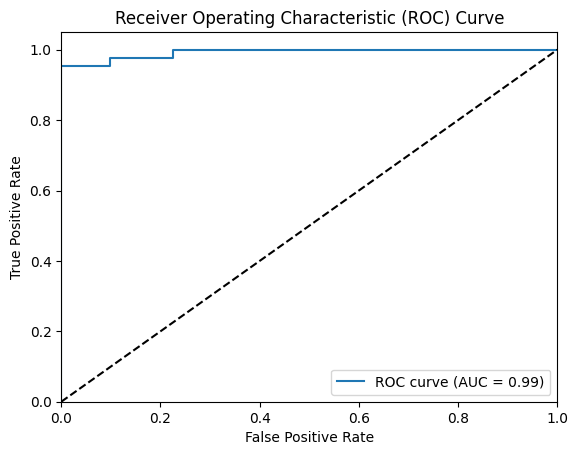

In [12]:
# Evaluate the model
evaluate_model(model, test_loader)

## Saving the Model and Predictions

In [14]:
# Save the model
torch.save(model.state_dict(), 'cancer_classifier_model.pth')

with torch.no_grad(): #  Diable gradient calculation, we dont want to update the weights
    X_scaled = scaler.fit_transform(X)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
    output = model(X_tensor)
    predictions = torch.sigmoid(output).numpy()
    predicted_classes = (predictions > 0.5).astype(int)

df['predicted'] = predicted_classes
df['predicted'] = df['predicted'].map({1: 'M', 0: 'B'})
df['diagnosis'] = df['diagnosis'].map({1: 'M', 0: 'B'})
df['predicted_prob'] = predictions

df.head()


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,predicted,predicted_prob
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M,0.731059
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M,0.731059
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M,0.731059
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M,0.731059
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M,0.731059


In [15]:
diagnosis_vs_predicted = df[['diagnosis', 'predicted']]
diagnosis_vs_predicted.head(20)

,diagnosis,predicted
0,M,M
1,M,M
2,M,M
3,M,M
4,M,M
5,M,M
6,M,M
7,M,M
8,M,M
9,M,M


/tmp/ipykernel_160081/3398393207.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_true = diagnosis_vs_predicted['diagnosis'].replace({'M': 1, 'B': 0})
/tmp/ipykernel_160081/3398393207.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred = diagnosis_vs_predicted['predicted'].replace({'M': 1, 'B': 0})


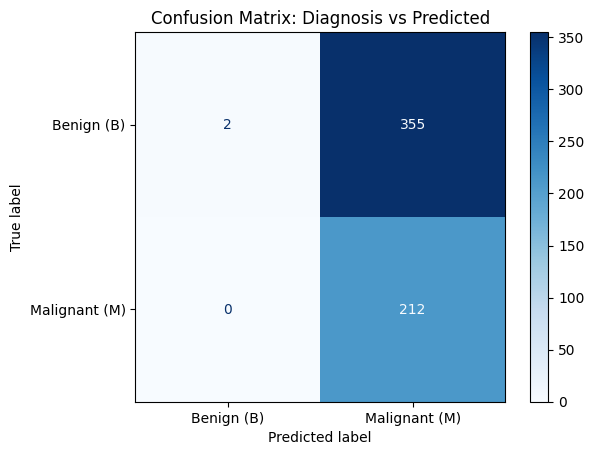

In [16]:
y_true = diagnosis_vs_predicted['diagnosis'].replace({'M': 1, 'B': 0})
y_pred = diagnosis_vs_predicted['predicted'].replace({'M': 1, 'B': 0})

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign (B)', 'Malignant (M)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Diagnosis vs Predicted")
plt.show()